In [5]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [6]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [7]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [8]:
season_length = 12 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='M',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [9]:
# Generate forecasts for the specified horizon using the sf object
horizon = 6
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon)
Y_hat_df.head(5)

,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2023-01-31,145.905945,144.227417,141.458527,136.738327
AAPL,2023-02-28,142.569733,145.345184,145.446686,142.126160
AAPL,2023-03-31,141.066406,146.462952,147.355850,141.644348
AAPL,2023-04-30,142.051804,147.580719,146.932388,142.016327
AAPL,2023-05-31,139.771881,148.698486,143.112045,145.042755


In [10]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
         mae          mse      mape       rmse     smape:
0  31.138555  1292.278419  0.170432  35.948274  19.155052

Model: AutoETS
         mae         mse      mape       rmse     smape:
0  26.809156  946.809306  0.146953  30.770267  16.208057

Model: AutoTheta
         mae          mse      mape       rmse     smape:
0  28.285301  1049.673646  0.155285  32.398667  17.210229

Model: CES
         mae          mse      mape       rmse     smape:
0  30.383822  1087.797419  0.169141  32.981774  18.706637

Results for MSFT:
Model: AutoARIMA
         mae         mse      mape       rmse     smape:
0  67.641342  5741.88572  0.211231  75.775232  24.264601

Model: AutoETS
         mae          mse      mape       rmse     smape:
0  56.587537  4082.634758  0.176257  63.895499  19.806992

Model: AutoTheta
         mae          mse      mape       rmse    smape:
0  63.646332  4898.045373  0.199913  69.986037  22.65309

Model: CES
         mae          mse      

In [11]:
cv_df = sf.cross_validation(df=Y_train_df, h=6, n_windows=3, step_size=6, level=[99])
cv_df.head()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2021-08-01,2021-07-01,149.278595,148.125366,140.706375,155.544357,143.434814,100.408531,186.461105,149.235397,141.925201,156.694321,147.177612,135.464249,159.213409
AAPL,2021-09-01,2021-07-01,139.330643,147.973694,136.208633,159.738754,143.461639,82.401703,204.521561,140.035080,129.922455,151.149658,148.665833,136.411362,161.231964
AAPL,2021-10-01,2021-07-01,147.503372,151.246735,137.418091,165.075378,143.488449,68.442513,218.534393,144.875259,132.153107,157.834717,152.117325,140.195908,164.519623
AAPL,2021-11-01,2021-07-01,162.765747,157.493530,142.126877,172.860199,143.515274,56.553436,230.477097,145.480423,129.490234,162.532501,154.867432,142.193512,166.598877
AAPL,2021-12-01,2021-07-01,175.102798,164.841309,147.701218,181.981415,143.542084,45.971149,241.113022,142.188705,124.706215,157.275757,158.478302,146.009644,170.539642


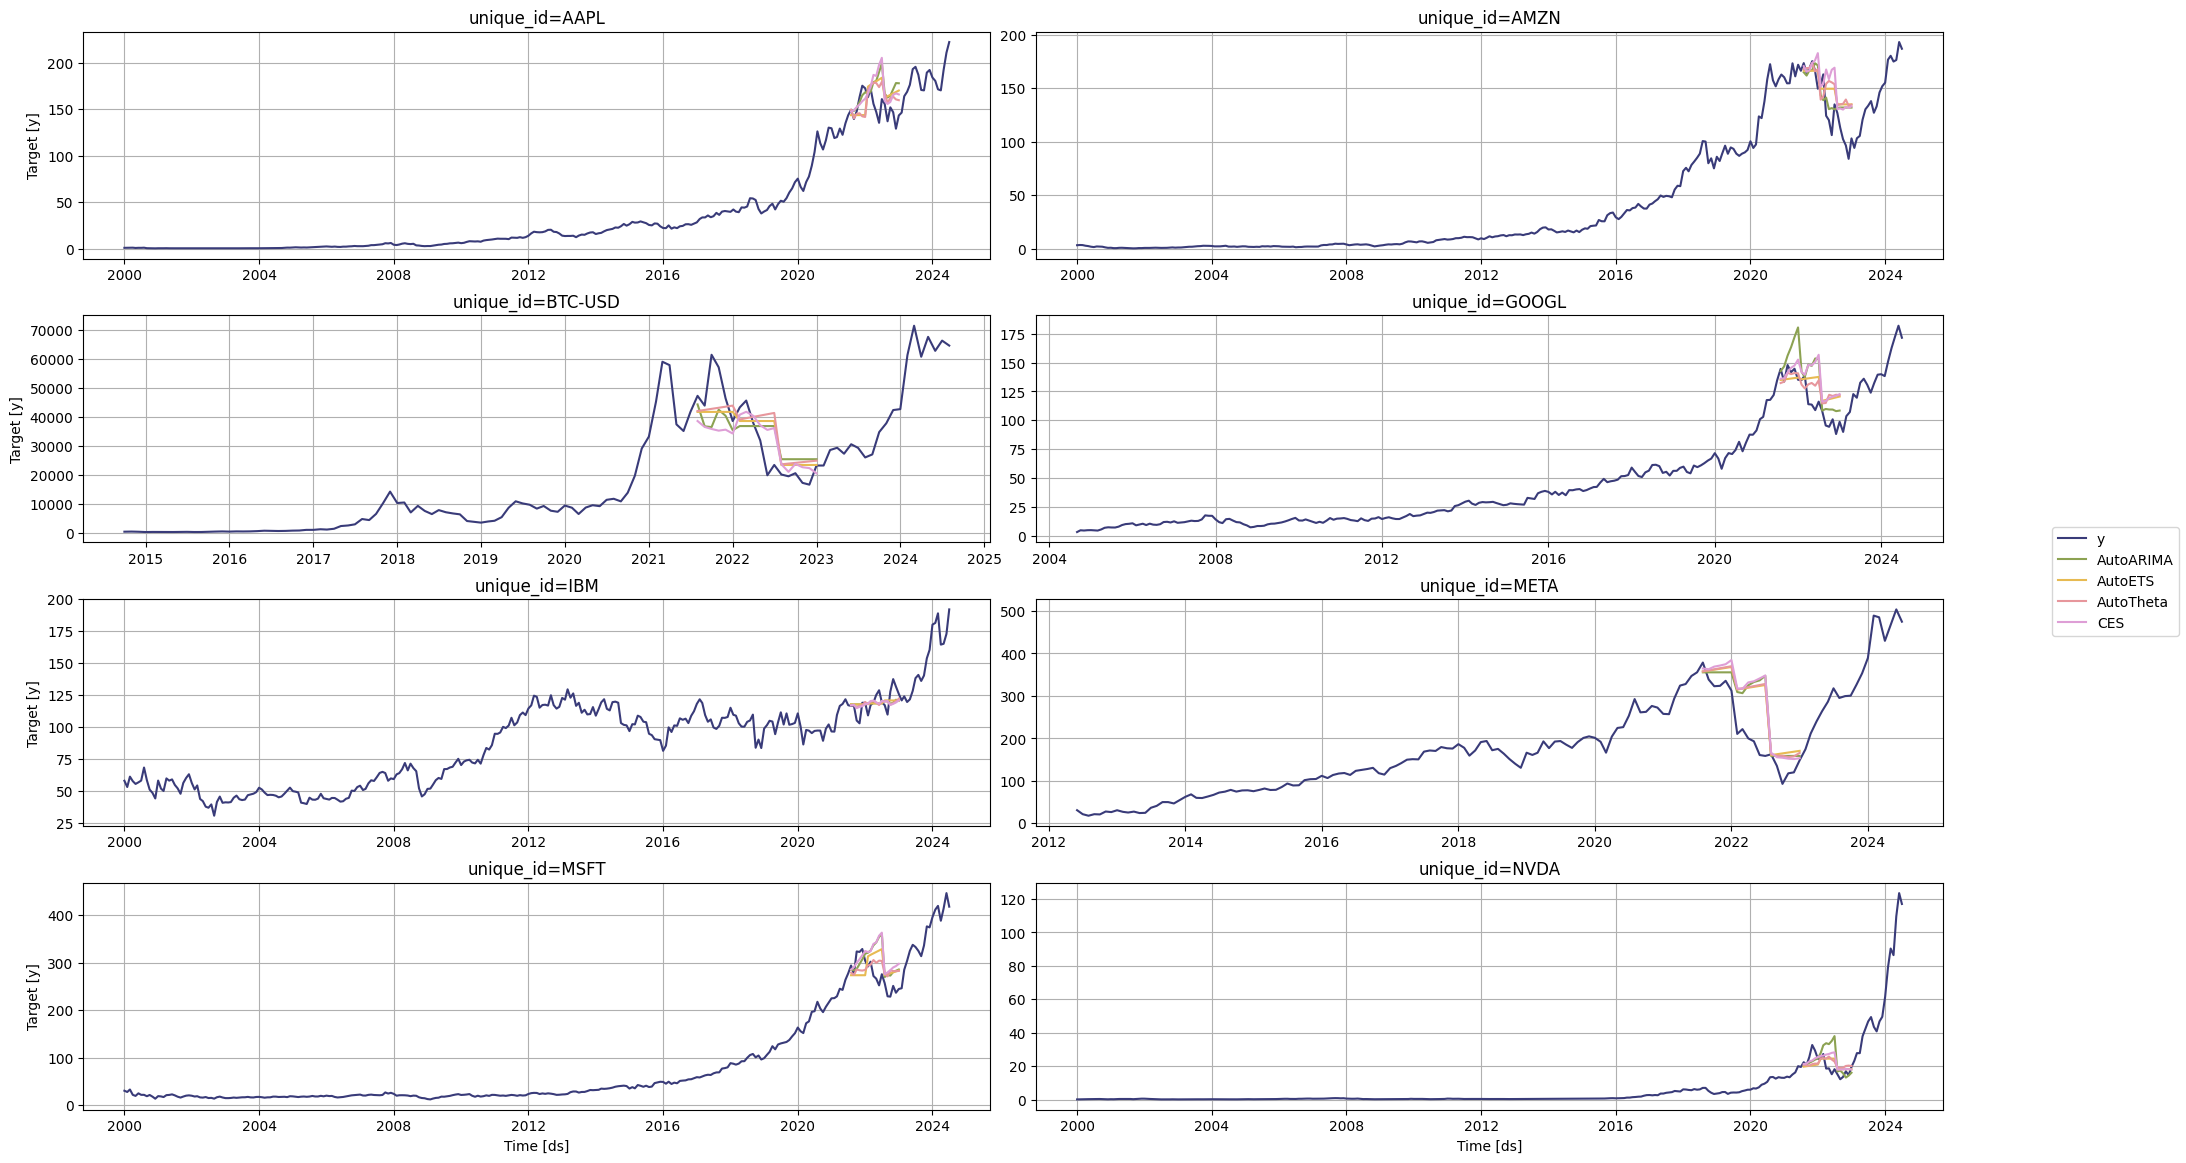

In [12]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))